In [60]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import text_to_word_sequence

import time

from Levenshtein import distance as lev
from sklearn.feature_extraction.text import CountVectorizer

import torch
from d2l import torch as d2l

/home/nienke/Documents/jupyternotebookenvnew/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Read (pass)words from file
Initially we only read the first 100 passwords

If you want to read all the lines, use .readlines()

In [2]:
def read_passwords(filename, comp_nr_lines, nr_lines):
    passwords = []
    comparison_pw = []

    with open(filename, "r") as file:
        for i in range(comp_nr_lines):
            comparison_pw.append(next(file).strip())
        for i in range(nr_lines):
            passwords.append(next(file).strip())
            
    return passwords, comparison_pw
        

In [3]:
def read_words(filename, nr_lines):
    words = []
    with open(filename, "r") as file:
        for i in range(nr_lines):
            words.append(next(file).strip().split("\t")[1])
    return words

In [4]:
def create_feature_labels(passwords, words):
    return np.concatenate((np.ones(len(passwords)), np.zeros(len(words))), axis=0)

In [5]:
def create_nn_labels(passwords, words):
    return torch.hstack((torch.concatenate((torch.ones((1,len(passwords))), torch.zeros(1,len(words))), axis=0),
                         torch.concatenate((torch.zeros((1,len(passwords))), torch.ones((1,len(words)))), axis=0)))



Passwords are 1 and nonpassword strings are 0

# Feature selection
Build features


## Levenshtein
To speed up this calculation, it might be worth it to create an implementation of Levenshtein that stops as soon as a distance larger than the current lowest is found. This lowers the average time complexity (but not worst case)

In [6]:
def calculate_levenshtein_distance(word, passwords):
    low = 42000
    for pw in passwords:
        d = lev(word, pw, score_cutoff=low-1)
        if d < low:
            low = d
        if low == 0:
            return low
    return low

## Other features

In [7]:

def count_non_repeating(text):
    '''
    Remove repeating letters from a string
    E.g. aaabbbccccccaaa becomes abca
    
    text: input text
    return: text without repeating letters
    '''
    count = 0
    for i, c in enumerate(text):
        if i ==0 or c != text[i-1]:
            count += 1
    return count



def counts(word, levenshtein=False):
    alpha_lower = 0
    alpha_upper = 0
    numeric = 0
    special = 0
    s = ""
    for c in word:
        if c.islower():
            alpha_lower += 1
            s += 'L'
        elif c.isupper():
            alpha_upper += 1
            s += 'U'
        elif c.isnumeric():
            numeric += 1
            s += 'N'
        else:
            special += 1
            s += 'S'
    length = len(word)
    char_sets = bool(alpha_lower) + bool(alpha_upper) + bool(numeric) + bool(special)
    if levenshtein: 
        lev_d = calculate_levenshtein_distance(word, comparison_pw)
        return [length, alpha_lower, alpha_lower/length, alpha_upper, alpha_upper/length, numeric, numeric/length, special, special/length, char_sets, count_non_repeating(s), lev_d]
    else:
        return [length, alpha_lower, alpha_lower/length, alpha_upper, alpha_upper/length, numeric, numeric/length, special, special/length, char_sets, count_non_repeating(s)]
    


## ngram features

In [8]:
#def word2ngrams(word, n=2):
#    return [' ' + word[:n-1]] + ["".join(j) for j in zip(*[word[i:] for i in range(n)])] + [word[-(n-1):] + ' ']

In [9]:
#print(word2ngrams("test", 2))


# Machine Learning shizzle

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [11]:
def print_errors(y_test, y_pred):
    for i in range(len(y_test)):
        if y_test[i] != y_pred[i]:
            print(words_test[i])
            print(y_test[i])
            print('')

In [12]:
def average_confusion_matrix(matrices):
    cumul_matrices = np.zeros(matrices[0].shape)
    for matrix in matrices:
        cumul_matrices = np.add(cumul_matrices, matrix)
    return cumul_matrices / len(matrices)
        

In [13]:
def run_ML_model(total, labels, nr_splits = 10, model = "decisiontree"):
    
    accuracies = []
    confusion_matrices = []
    
    kf = KFold(n_splits = nr_splits, shuffle=True, random_state = 42)
    for train, test in kf.split(total):
        
        X_train_tot, X_test_tot, y_train, y_test = total[train], total[test], labels[train], labels[test]
        X_train = [features for _, features in X_train_tot]
        words_train = [words for words, _ in X_train_tot]

        X_test = [features for _, features in X_test_tot]
        words_test = [words for words, _ in X_test_tot]


        # pick model
        if model == "decisiontree":
            clf = tree.DecisionTreeClassifier()
        elif model == "randomforest":
            clf = RandomForestClassifier(max_depth = 10, random_state=0)
        elif model == "GaussianNB":
            clf = GaussianNB()
        elif model == "MultinomialNB":
            clf = MultinomialNB()
        else:
            raise ValueError('Unknown model type supplied: "{}". Please specify a different model type'.format(model))

        clf.fit(X_train, y_train)
    
    
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_pred, y_test))
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
    
    
    print("Accuracy score: {}".format(np.mean(accuracies)))

    print("\nConfusion matrix:")
    print(average_confusion_matrix(confusion_matrices))
    

# Neural networks

In [62]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import torch.nn.functional as F

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

import time
from collections import Counter, defaultdict
from itertools import chain

In [88]:
n_epochs = 5
lr = 0.01
n_folds = 2
lstm_input_size = 32
hidden_state_size = 256
n_layers = 2
dropout = 0.125
bidirectional = True
batch_size = 64
num_sequence_layers = 2
output_dim = 2                       # !!!!!!!!!!!!!!!!!!!!!!!!
num_time_steps = 30                 # !!!!!!!!!!!!!!
rnn_type = 'LSTM'

In [16]:
class CharacterDataset(Dataset): 
    """Custom dataset. Parameters
---------- text : str Input text that will be used to create the entire database. window_size : int
Number of characters to use as input features. vocab_size : int Number of characters in the vocabulary.
Note that the last character is always reserved for a special "~" out-of-vocabulary character. Attributes
---------- ch2ix : defaultdict Mapping from the character to the position of that character in the
vocabulary. Note that all characters that are not in the vocabulary will get mapped into the index `vocab_size -
1`. ix2ch : dict Mapping from the character position in the vocabulary to the actual character.
vocabulary : list List of all characters. `len(vocabulary) == vocab_size`. """ 
    
    def __init__(self, texts, y, max_len=32, vocab_size=25): 
        self.texts = texts
        self.y = y
        self.max_len = max_len
        self.ch2ix = defaultdict(lambda: vocab_size - 1) 
        
        concat_text = chain.from_iterable(self.texts)
        most_common = Counter(concat_text).most_common()
        for (c, n) in most_common:
            if "~" == c:
                most_common.remove(("~", n))
                break
        most_common_ch2ix = { 
            x[0]: i 
            for i, x in enumerate(most_common[: (vocab_size - 1)]) 
        }
            
        self.ch2ix.update(most_common_ch2ix) 
        self.ch2ix["~"] = vocab_size - 1 
        
        self.ix2ch = {v: k for k, v in self.ch2ix.items()} 
        for i in range(len(most_common)-1, vocab_size):
            self.ix2ch[i] = "~"
        self.vocabulary = [self.ix2ch[i] for i in range(vocab_size)] 
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, ix): 
        X = torch.LongTensor(
            [self.ch2ix[c] for c in self.texts[ix]] 
        )
        if len(X) > self.max_len:
            X = X[:self.max_len]
        X = nn.ConstantPad1d((0, self.max_len - len(X)), 0)(X)
        y = self.y[ix] 
        
        return X, y

    
dataset = CharacterDataset(["Dit is een testtekst self.ch2ix.update(most_common_ch2ix) self.ch2ix[\"~\"] = vocab_size - 1 self.ix2ch = {v: k for k, v in", "test 2"], 
                           torch.transpose(torch.tensor([[0., 1., 1., 0., 0., 0.], [0., 0., 0., 1., 1., 1.]]), 0,1), max_len=32, vocab_size=100)

print(dataset)

loader = DataLoader(dataset)

print(loader)

print(next(iter(loader)))
for i, l in enumerate(loader):
    print(i, l)


[tensor([[21,  4,  2,  0,  4,  3,  0,  1,  1, 12,  0,  2,  1,  3,  2,  2,  1, 13,
          3,  2,  0,  3,  1, 14,  8,  9,  5, 10,  6,  4, 11,  9]]), tensor([[0., 0.]])]
0 [tensor([[21,  4,  2,  0,  4,  3,  0,  1,  1, 12,  0,  2,  1,  3,  2,  2,  1, 13,
          3,  2,  0,  3,  1, 14,  8,  9,  5, 10,  6,  4, 11,  9]]), tensor([[0., 0.]])]
1 [tensor([[2, 1, 3, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), tensor([[1., 0.]])]


Do not use anymore, just here for reference




class Dataset_Sequential(Dataset):
    def __init__(self, input, output):
        self.embedding = nn.Embedding(100,32)
        self.input = self.embedding(input)
        self.output = output
        

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx]
        y = self.output[idx]
        # Embed the input in numbers rather than characters
        x = self.embedding(x)
        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.float)
        return x, y

class Dataset_Sequential_test(Dataset):
    def __init__(self, input):
        self.embedding = nn.Embedding(100,32)
        self.input = self.embedding(input)
        
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx]
        # Embed the input in numbers rather than characters
        x = self.embedding(x)
        x = torch.tensor(x, dtype=torch.str)
        return x

In [89]:
class Bi_RNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=11, vocab_size=100, max_len = 32, num_layers=2, rnn_type='LSTM'):
        super(Bi_RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        # Define embedding; arguments: num_embeddings, embedding_dim
        self.embedding = nn.Embedding(vocab_size, max_len, padding_idx = vocab_size -1)

        # Define the LSTM layer
        self.lstm = eval('nn.' + rnn_type)(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=bidirectional)

        # Define the output layer
        self.linear1 = nn.Linear(512,128)
        self.linear2 = nn.Linear(128,8)
        self.linear3 = nn.Linear(8,2)
        
        self.tanh = nn.Tanh()
        self.maxpool = nn.MaxPool1d(32)
        

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers*2, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers*2, self.batch_size, self.hidden_dim))

    def forward(self, input):
        
        input = self.embedding(input)
        
        # Creating PackedSequence
        #packing = nn.utils.rnn.pad_sequence(input)
        #                                                  !!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Insert packing stuff
        
        self.hidden = self.init_hidden()

        
        #print(input.dtype)
        #self.hidden = self.init_hidden()
        #print(self.hidden[0].dtype)
        
        #print(input.shape)
        #print(self.hidden[0].shape)
        #print(self.hidden[1].shape)
        # Forward pass through LSTM layer
        # shape of lstm_out: [batch_size, input_size ,hidden_dim]
        # shape of self.hidden: (a, b), where a and b both
        # have shape (batch_size, num_layers, hidden_dim).
        input, self.hidden = self.lstm(input, self.hidden)
        #print(self.hidden[0].shape)
        #print(input.shape)
        
        # Unpacking PackedSequence
        #                                                  !!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Insert packing stuff
        
        
        # Something with Permute???????                    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        input = torch.permute(input, (0,2,1))
        
        # Tanh
        input = self.tanh(input)
        
        # MaxPool 1D
        input = self.maxpool(input)
        #print(input.shape)
        
        # Tanh
        input = self.tanh(input)
        #print(input.shape)
        
        # Squeeze
        input = torch.squeeze(input)
        #print(input.shape)
        
        # First linear layer
        input = self.linear1(input)
        
        # Dropout
        
        # Second linear layer
        input = self.linear2(input)
        
        # Dropout
        
        # Third linear layer
        output = self.linear3(input)
        
        return output


In [90]:
def load_data():
    test = Dataset_Sequential_test(X_test)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [91]:
m = nn.MaxPool1d(3, stride = 2)
input = torch.randn(3, 4, 5)
output = m(input)
print(input)
print(output)

tensor([[[ 2.9206e+00,  4.1626e-02, -9.6081e-01, -1.3490e-01,  5.4243e-01],
         [-2.8423e-03, -1.8852e+00, -2.0596e-01, -8.1712e-02, -7.7423e-01],
         [ 1.4196e+00,  6.1677e-01,  1.1426e+00,  3.9732e-01, -8.5400e-02],
         [ 4.9027e-01,  7.4072e-01,  9.4999e-01, -1.5745e+00,  6.6183e-01]],

        [[ 3.2888e+00,  5.3033e-02,  8.7453e-01,  1.3980e+00,  1.4096e-01],
         [-4.4690e-01, -9.8567e-01,  1.8121e-01,  1.3080e+00,  1.7065e+00],
         [ 1.2369e+00,  3.2201e-01, -1.1146e+00,  1.9961e+00,  5.2553e-01],
         [ 5.6661e-01, -1.4704e-01,  8.5648e-01,  3.9272e-01,  6.5177e-01]],

        [[ 6.1465e-01,  2.9489e-01, -2.0272e+00,  1.1708e+00, -5.1361e-01],
         [-2.9576e-01, -3.0109e-01, -1.3961e+00,  5.0110e-01, -6.1576e-02],
         [-1.4946e+00,  1.0160e-01, -7.2072e-01, -1.2364e+00,  4.0867e-01],
         [ 8.5834e-01, -4.9086e-01,  1.1764e+00, -9.4770e-01, -1.1134e+00]]])
tensor([[[ 2.9206e+00,  5.4243e-01],
         [-2.8423e-03, -8.1712e-02],
        

In [92]:
def train(net, words_train, y_train, epochs=100, lr=0.01, device=d2l.try_gpu()):
    # Trains the model net with data from the data_loaders['train'] and data_loaders['val'].
    
    
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    local_val_score = 0
    models = {}
    
    y_train = torch.transpose(y_train, 0, 1)
    nr_classes = 2
    vocab_size = 25
    #print(len(words_train))
    #print(y_train.shape)

    k=0 #initialize fold number
    for tr_idx, val_idx in kfold.split(words_train, y_train):

        print('starting fold', k)
        k += 1

        print(6*'#', 'splitting and reshaping the data')
        words_train = np.array(words_train).flatten()
        train_input = words_train[tr_idx]
        train_target = y_train[tr_idx]
        val_input = words_train[val_idx]
        val_target = y_train[val_idx]
    
        train = CharacterDataset(train_input, train_target, vocab_size=vocab_size)
        valid = CharacterDataset(val_input, val_target, vocab_size=vocab_size)
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last = True)
        valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False, drop_last = True)
        data_loaders = {'train': train_loader,
                        'val': valid_loader}


        net = net.to(device)

        optimizer = torch.optim.Adam(net.parameters(), lr=lr)

        animator = d2l.Animator(xlabel='epoch',
                                legend=['train loss', 'train acc', 'validation acc'],
                                figsize=(10, 5))

        timer = {'train': d2l.Timer(), 'val': d2l.Timer()}

        for epoch in range(epochs):
            # monitor loss, accuracy, number of samples
            metrics = {'train': d2l.Accumulator(3), 'val': d2l.Accumulator(3)}

            for phase in ('train', 'val'):
                # switch network to train/eval mode
                net.train(phase == 'train')

                for i, (x, y) in enumerate(data_loaders[phase]):
                    timer[phase].start()

                    # move to device
                    x = x.to(device)
                    y = y.to(device)

                    # compute prediction
                    y_hat = net(x)

                    if y_hat.shape[1] == 1:
                        # compute binary cross-entropy loss
                        loss = torch.nn.BCEWithLogitsLoss()(y_hat[:, 0], y.to(torch.float))
                    else:
                        # compute cross-entropy loss
                        loss = torch.nn.CrossEntropyLoss()(y_hat, y)

                    if phase == 'train':
                        # compute gradients and update weights
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    
                    
                    #print(y.shape)
                    #print(y_hat.shape)

                    metrics[phase].add(loss * x.shape[0],
                                       accuracy(y_hat, y) * x.shape[0],
                                       x.shape[0])

                    timer[phase].stop()

            animator.add(epoch + 1,
                (metrics['train'][0] / metrics['train'][2],
                 metrics['train'][1] / metrics['train'][2],
                 metrics['val'][1] / metrics['val'][2]))

        train_loss = metrics['train'][0] / metrics['train'][2]
        train_acc  = metrics['train'][1] / metrics['train'][2]
        val_acc    = metrics['val'][1] / metrics['val'][2]
        examples_per_sec = metrics['train'][2] * epochs / timer['train'].sum()

        print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
              f'val acc {val_acc:.3f}')
        print(f'{examples_per_sec:.1f} examples/sec '
              f'on {str(device)}')

In [111]:
def accuracy(y_hat, y):
    # Computes the mean accuracy.
    # y_hat: raw network output (before sigmoid or softmax)
    #        shape (samples, classes)
    # y:     shape (samples)
    '''if y_hat.shape[1] == 1:
        # binary classification
        y_hat = (y_hat[:, 0] > 0).to(y.dtype)
    else:
        # multi-class classification
        y_hat = torch.argmax(y_hat, axis=1).to(y.dtype)
    '''
    #print(y_hat)
    y_hat = (y_hat >= 0.5).to(y.dtype)
    #print(y_hat)
    
    correct = (y_hat == y).to(torch.float32)
    return torch.mean(correct)

# Run experiments
The following code allows you to run experiments

In [113]:
pw_filename = "10-million-password-list-top-1000000.txt"
text_filename = "eng_news_2020_1M-words.txt"
comp_nr_lines = 10000
nr_lines = 1500

In [114]:
# Load data
passwords, comparison_pw = read_passwords(pw_filename, comp_nr_lines, nr_lines)
words = read_words(text_filename, nr_lines)
#print(words)
print("Nr of passwords: {}\nNr of words: {}".format(len(passwords), len(words)))

all_words = passwords + words


Nr of passwords: 1500
Nr of words: 1500


In [115]:
# replace next line as soon as we have code that reads in the text file
#text = "Previous research has shown that language and culture influence what passwords look like. Li et al. (2014) compared Chinese and English passwords, and found several differences. First of all, Chinese speakers prefer to use digits while English speakers prefer letters, especially lowercase letters; around 50% of the Chinese passwords were digits only. Besides that, all users use patterns that they are familiar with. In the case of Chinese speakers, this is pinyin words, while in the case of English speakers, these are English words. Finally, they also find that users tend to use date formats that are customary in their culture (e.g. 0104 or 0401 for April 1st). Wang et al. (2019), who also compared Chinese and English passwords, add to this that there are difference in the letter distributions of password groups. For example, Chinese passwords use the letter q more often than English passwords do, likely because q is a common letter in pinyin, but quite rare in English. These distributions do not exactly match the distributions of the languages completely. For example, they found that the letters l and w occurred more often in passwords than in general Chinese pinyin. They argue that this is likely because they are part of the very popular Chinese names Li and Wang. Furthermore, Wang et al. (2019) add that around 11% of Chinese passwords contain a pinyin name (compared to 4% in their English passwords dataset) and about 31% include a 4+ digit date in their password, of which 17% include a 6 digit date. Note that these percentages are likely overestimations as it is not always possible to determine of a number sequence whether it is a date or refers to something else. All these numbers are significantly higher than in the English password set. Phone numbers are also possible passwords. De Tweede Kamerleden waren het er snel over eens: als ze onderzoek wilden doen naar beïnvloeding van moskeeën, dan móésten ze Lorenzo Vidino wel uitnodigen. De gelauwerde extremisme-deskundige uit de Verenigde Staten had er boeken over geschreven, parlementen voorgelicht, regeringen geadviseerd. Dus leek het een logische keuze voor de Kamercommissie die in 2019 onderzoek deed naar buitenlandse moskeefinanciering, om Vidino te horen als expert. Het werd een „heel interessant gesprek”, herinnert een van de commissieleden zich, die anoniem wil blijven omdat de zitting achter gesloten deuren plaatsvond. „Hij schetste een gedetailleerd beeld van de Nederlandse vertakkingen van de Moslimbroederschap.” De islamitische beweging zou hier volgens Vidino „verdeeldheid” zaaien. Hij kon meerdere Nederlandse moskeeën bij naam noemen die onder invloed zouden staan van de Moslimbroeders en wist zelfs de exacte hoogte van ontvangen giften uit Qatar."
#words = text_to_word_sequence(text, lower=False)

# Run feature-based models
labels = create_feature_labels(passwords, words)

labels_nn = create_nn_labels(passwords, words)
print(labels_nn)


tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])


## Feature-based models

We have the following feature settings

- base_features: simple feature set such as the length of the word and amount of characters from different character sets
- levenshtein: calculate the Levensthein distance to most common passwords
- ngrams: ngram of characters as features
- ngram_range: if ngrams is true, this setting determines which ngrams are to be taken into account

In [23]:
base_features = True
levenshtein = False
ngrams = False
ngram_range = (1, 2)

In [98]:
start_time = time.time()

features = [counts(pw, levenshtein=levenshtein) for pw in passwords]
features_word = [counts(word, levenshtein=levenshtein) for word in words]
features = np.concatenate((features, features_word), axis=0)


if ngrams: 
    vectorizer = CountVectorizer(analyzer = 'char', lowercase = False, ngram_range = ngram_range)
    ngram_features = vectorizer.fit_transform(all_words)
    # CountVectorizer returns a sparse matrix. This needs to be converted into a dense matrix in order to be able to concatenate it.
    features = np.concatenate((np.array(features), ngram_features.toarray()), axis=1)

# link features and words
total = np.array(list(zip(all_words, features)))

run_ML_model(total, labels, model="decisiontree")

print("--- %s seconds ---" % (time.time() - start_time))


Accuracy score: 0.858

Confusion matrix:
[[42.5  7.5]
 [ 6.7 43.3]]
--- 0.059490203857421875 seconds ---


/tmp/ipykernel_78947/4249568652.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total = np.array(list(zip(all_words, features)))


In [26]:
x_batch = torch.Tensor(1, 30, 32)
print(x_batch.shape)
x_batch = x_batch.reshape(-1, num_time_steps, lstm_input_size)
print(x_batch.shape)

m = nn.MaxPool1d(3)
m

torch.Size([1, 30, 32])
torch.Size([1, 30, 32])


MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)

In [100]:
# Run neural network model
#run_LSTM(all_words, labels_nn)

# NIET VERGETEN:
#   Dropout toevoegen

train loss 0.255, train acc 0.847, val acc 0.696
264.5 examples/sec on cpu


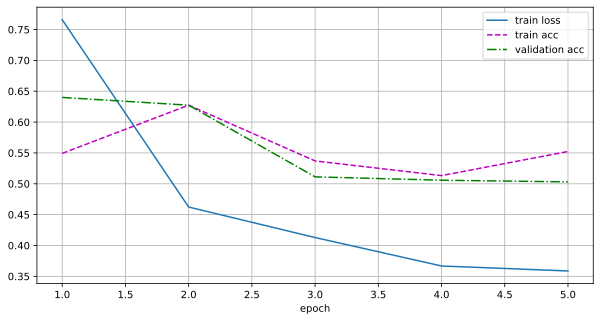

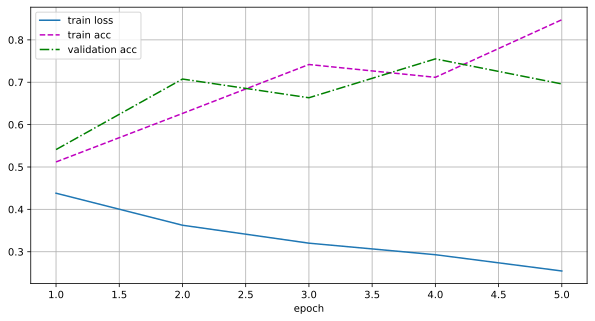

In [116]:
model = Bi_RNN(lstm_input_size, hidden_state_size, batch_size=batch_size, output_dim=output_dim, num_layers=num_sequence_layers, rnn_type=rnn_type)  # (input_dim, hidden_state_size, batch_size, output_dim, num_seq_layers, rnn_type)

train(model, all_words, labels_nn, epochs = 5)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)


CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 3, just so you can see what they look like.
print(ngrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["beauty"]])